In [1]:
# Import modules

import os
import pandas as pd
import numpy as np
import scipy.stats as sp
import datetime
import seaborn as sns
from datetime import date, timedelta
from matplotlib import pyplot as plt
from scipy.stats import skew

sns.set_style(style='whitegrid')
sns.set_palette(palette='colorblind')

In [2]:
# Petter's code for extracting all the data files and then combining them.

def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

In [3]:
# Extration of all the acitvity data into one data frame

df = extract_folder('../data/depresjon')
df.shape


(1571706, 5)

In [104]:
# Function to clasify each row of data as either day (0) or night (1) 

def day_or_night (dataframe,day_start,day_end):
    
    # day night classifying function
    def day_night_test(time):
        if day_start <= time.hour < day_end:
            return (0)
        else:
            return (1)
    
    # Create a copy of the data frame
    dayNight_df = dataframe.copy()
    
    # Add in the new column with day or night values
    dayNight_df['day_night'] = dayNight_df['timestamp'].apply(day_night_test)
    return (dayNight_df)

# Day values using rodriguez model values of 8:00 - 20:00. 

DN_df = day_or_night(df,8,20)

In [105]:
# Function to create a field of acitve (1) and non-active (0) time

def active_nonactive (dataframe):
    
    # function to test if a minute is active ('1') or inactive('0')
    def time_test(activity):
        if activity < 5:
            return ('0')
        else:
            return ('1') 
    
    # Create a copy of the data frame    
    new_df = dataframe.copy()
    
    # Create a new column classifying each minute as acitve or inactive
    new_df['col1'] = new_df['activity'].apply(time_test)
    
    # Create a new column that sums the 11 values (5 below and 5 above) the trigger value 
    new_df['col2'] = new_df['col1'].rolling(window=11, center=True).sum()
    
    # Function to test if a period is active or inactive
    def activ_test(value):
        if value >= 2:
            return (1)    
        elif value < 2:
            return (0)
        else:
            return ('NaN')
        
    # Create the column of active or inactive periods   
    new_df['active_inactive'] = new_df['col2'].apply(activ_test)
    
    # Drop the unnecessary columns created
    new_df.drop(['col1','col2'], axis=1, inplace=True)
    
    return(new_df)

active_df = active_nonactive(DN_df)

In [117]:
# Read in sunlight data obtain from the website
# Sunrise and sunset by month for Oslo 
# 'https://www.worlddata.info/europe/norway/sunset.php'

sunlight = pd.read_csv('data/depresjon/Norway_Sunlight.csv')

# add month column for merging 
active_df['month'] = pd.to_datetime(active_df['timestamp']).dt.month

# merge dataframes
merged_df = active_df.copy()
merged_df = pd.merge(merged_df, sunlight, on='month', how='inner')

# remove unnecessary columns       
merged_df.drop('month', axis=1, inplace=True)

In [118]:
# Function to clasify each row of data as either light (0) or dark (1) 

def light_dark(dataframe):
    
    # extract time, sunrise and sunset columns 
    # convert sunrise and sunset columns to time format        
    dataframe['time'] = pd.to_datetime(dataframe['timestamp']).dt.time
    sunrise = pd.to_datetime(dataframe['sunrise']).dt.time
    sunset = pd.to_datetime(dataframe['sunset']).dt.time
    time = dataframe['time']
        
    # create a list of when it is light(0) or dark(1)
    size = len(sunrise)
    light_dark = []
    for n in range (0,size):
        if sunrise[n] <= time[n] < sunset[n]:
            light_dark.append(0)
        else:
            light_dark.append(1)

    # add list as a new column 'light_dark' to dataframe    
    dataframe['light_dark'] = light_dark

    # remove unnecessary columns       
    dataframe.drop(['time','sunrise','sunset'], axis=1, inplace=True)
    
    return(dataframe)
    

LD_df = light_dark(merged_df)

C:\Users\44778\AppData\Local\Temp\ipykernel_45788\1526019979.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sunrise = pd.to_datetime(dataframe['sunrise']).dt.time
C:\Users\44778\AppData\Local\Temp\ipykernel_45788\1526019979.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sunset = pd.to_datetime(dataframe['sunset']).dt.time


In [119]:
def fullDays(dataframe):
    participants = dataframe['id'].unique()
    df_new = pd.DataFrame({})
    for participant in participants:
        df_tochange = dataframe[dataframe['id'] == participant]
        min_timestamp = df_tochange['timestamp'].min()
        min_date = df_tochange['date'].min()
        
        if min_date < min_timestamp:
            min_fullday_date = min_date + timedelta(1)
            df_minchange = df_tochange[df_tochange['date'] >= min_fullday_date]
        else:
            df_minchange = df_tochange.copy()
        
        max_timestamp = df_minchange['timestamp'].max()
        max_date = df_minchange['date'].max()
        
        if max_date < max_timestamp:
            df_maxchange = df_minchange[df_minchange['date'] < max_date]
        else:
            df_maxchange = df_minchange.copy()
        
        df_new = pd.concat([df_new,df_maxchange])
        
    return (df_new)

fulldays_df = fullDays(LD_df)

In [120]:
scores = pd.read_csv('data/depresjon/scores.csv')

def trueDates (dataframe):
    
    df_new = pd.DataFrame({})
    participants = dataframe['id'].unique()
    
    for participant in participants:
        
        df_tochange = dataframe[dataframe['id'] == participant]
        trueDays = scores.loc[scores['number'] == participant, 'days'].values[0]
        
        min_date = dataframe.loc[dataframe['id'] == participant, 'date'].min()
        min_truedate = min_date + timedelta(int(trueDays))
        
        df_reduce = df_tochange[df_tochange['date'] < min_truedate]
        df_new = pd.concat([df_new,df_reduce])
    
    return (df_new)

TD_df = trueDates(fulldays_df)

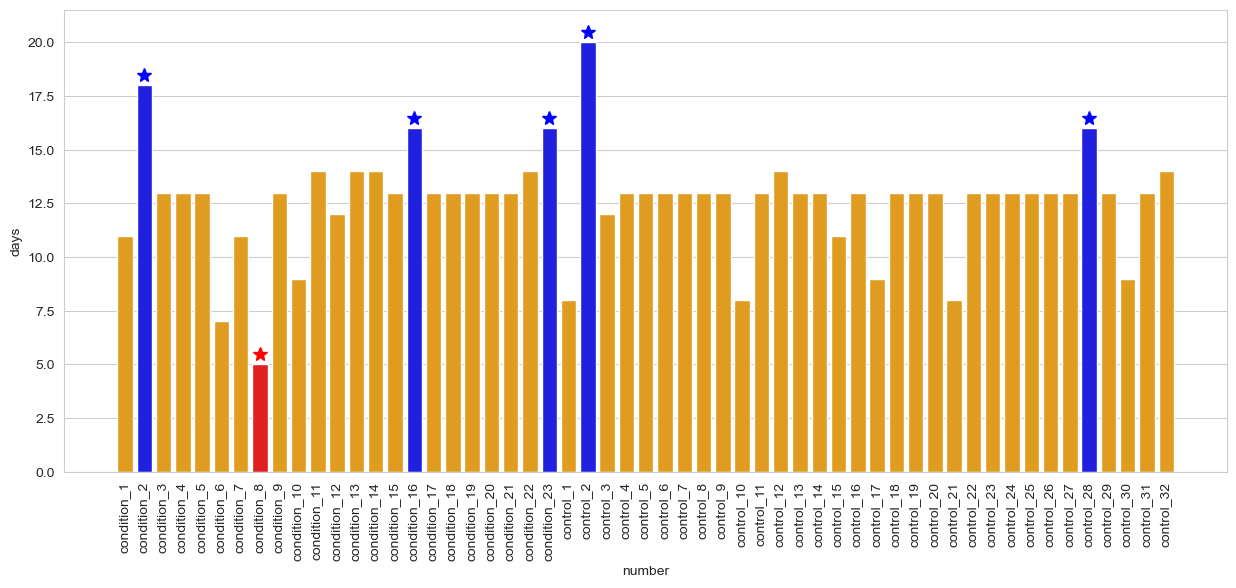

In [107]:
plt.figure(figsize=(15, 6))

palette = ['red' if condition == 'condition_8' 
           else 'blue' if condition in ['condition_16','condition_23','condition_2', 'control_2', 'control_28'] 
           else 'orange' for condition in scores['number']]

ax = sns.barplot(data=scores, x='number', y='days',color='blue',palette=palette)
plt.xticks(rotation=90)



ax.plot(7,5.5,"*", markersize=10, color="r")
ax.plot(1,18.5,"*", markersize=10, color="b")
ax.plot(24,20.5,"*", markersize=10, color="b")
ax.plot(50,16.5,"*", markersize=10, color="b")
ax.plot(15,16.5,"*", markersize=10, color="b")
ax.plot(22,16.5,"*", markersize=10, color="b")

plt.show()

In [121]:
def weekDays(dataframe):
    
    participants = dataframe['id'].unique()
    df_new = pd.DataFrame({})
    
    for participant in participants:
        
        df_tochange = dataframe[dataframe['id'] == participant]
        
        min_date = pd.to_datetime(df_tochange['date']).min()
        max_date = pd.to_datetime(df_tochange['date']).max()
        week = min_date + timedelta(7)   
        
        df_week = df_tochange[df_tochange['date'] < week]
                        
        df_new = pd.concat([df_new,df_week])
        
    return (df_new)

week_df = weekDays(TD_df)




In [122]:
clean_df = week_df[week_df['id'] != "condition_8"]

In [125]:
clean_df.isnull().sum()

timestamp          0
date               0
activity           0
id                 0
label              0
day_night          0
active_inactive    0
light_dark         0
dtype: int64

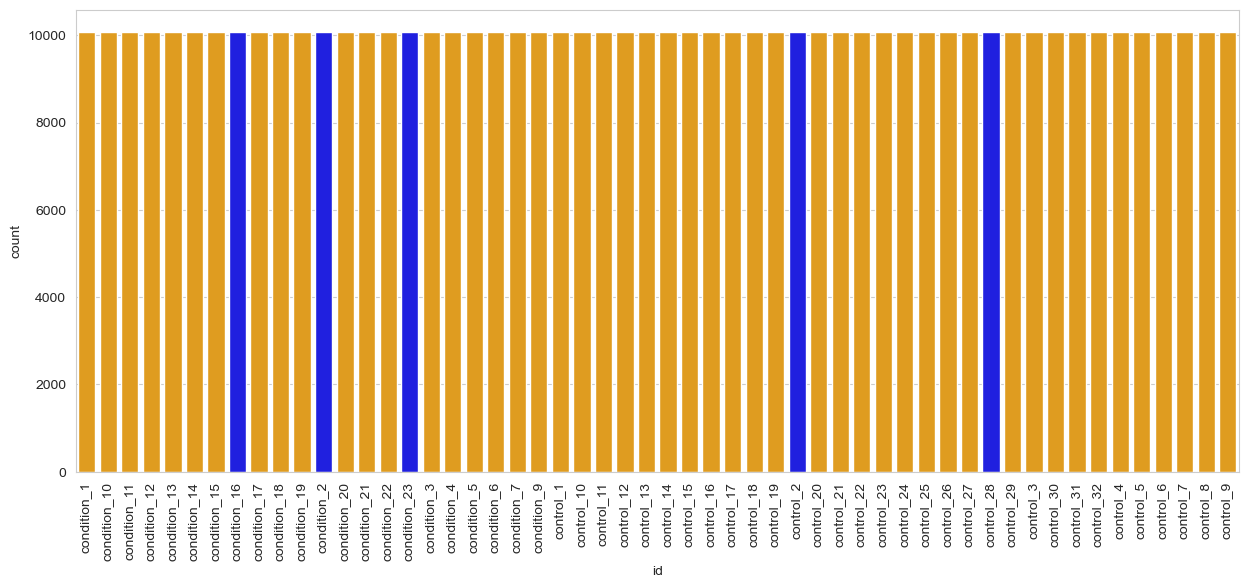

In [124]:
WD_df = clean_df.groupby('id').size().reset_index(name='count')

plt.figure(figsize=(15, 6))

palette = ['red' if condition == 'condition_8' 
           else 'blue' if condition in ['condition_16','condition_23','condition_2', 'control_2', 'control_28'] 
           else 'orange' for condition in WD_df['id']]




sns.barplot(data=WD_df, x='id', y='count',color='blue', palette=palette)
plt.xticks(rotation=90)
plt.show()